In [1]:
import os
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat/')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
print(font_manager.findfont("Arial"))
from matplotlib import rcParams
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["pdf.fonttype"] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'pdf')

/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf


In [3]:
# objects cleaned before patcher
gex_clean = sc.read_h5ad('pre_patcher_gex.h5ad')
ibex_gene = sc.read_h5ad('pre_patcher_ibex.h5ad')
# object after patcher with imputed genes and annotations
ibex_out = sc.read_h5ad('out_RNA_1m_KNN30_v3.h5ad')

In [4]:
gex_clean.shape
ibex_gene.shape
ibex_out.shape

(111054, 36601)

(764448, 42)

(764448, 36560)

In [5]:
ibex_gene_sub = ibex_gene[:, [i in gex_clean.var_names for i in ibex_gene.var_names]]
gex_clean_sub = gex_clean[:, ibex_gene_sub.var_names]
sc.pp.normalize_total(gex_clean_sub)
sc.pp.log1p(gex_clean_sub)
sc.pp.scale(gex_clean_sub, max_value=10)

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [6]:
np.quantile(ibex_gene_sub.X, [0.05, 0.25, 0.5, 0.75, 0.99])

array([ 0.09589585,  0.44222197,  0.9005602 ,  2.33450675, 27.59115881])

In [7]:
np.min(ibex_gene_sub.X)
np.mean(ibex_gene_sub.X)
np.max(ibex_gene_sub.X)

ArrayView(-9.63441563)

ArrayView(2.98184632)

ArrayView(470.51047505)

In [8]:

# Get unique samples
unique_samples = ibex_gene_sub.obs['sample'].unique()

# Dictionary to hold output for each sample
sample_dict = {}

# Run the function for each sample and append the result to the list in order to 
for sample in unique_samples:
    # subset sample
    ibex_gene_sample = ibex_gene_sub[ibex_gene_sub.obs['sample'] == sample]
    # scale each sample 
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1000))
    ibex_gene_sample.X = scaler.fit_transform(ibex_gene_sample.X)
    sc.pp.filter_cells(ibex_gene_sample, min_genes=3)
    #normalise to median
    sc.pp.normalize_total(ibex_gene_sample)
    sc.pp.log1p(ibex_gene_sample)
    sc.pp.scale(ibex_gene_sample, max_value=10)
    sample_dict[sample] = ibex_gene_sample

# Concatenate all the results
ibex_scaled_sub = sc.concat(sample_dict, join='outer')


/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/vk8/miniconda/envs/scvi-env/lib

In [9]:
ibex_scaled_sub.obs_names.equals(ibex_out.obs_names)

True

In [10]:
ibex_scaled_sub.obs['anno_CITE'] = ibex_out.obs['anno_CITE']
ibex_scaled_sub.obs['anno_CITE_fraction'] = ibex_out.obs['anno_CITE_fraction']
ibex_scaled_sub.obs['anno_CITE'].value_counts()

DP(P)                  188689
DP(Q)                   76508
DP_4hi8lo               68516
committed_CD4pos        60648
DP_pos_sel              46448
DP(Q)_rearr             46277
SP_CD8_semimature       25788
SP_CD4_semimature       21457
DP_early_CD31           19018
mcTEC                   15133
committed_CD4neg(P)     14537
mTECI                   13304
SP_CD4_immature         13089
committed_CD4neg        11011
CD8aaII_immature        10920
SP_Treg_mature          10521
cTECIII                  9581
SP_Treg_immature         8944
EC-Ven                   7540
B-memory                 6766
CD8aaI_mature            6439
aDC3                     6350
mTECII                   5511
InterloFb                5450
CD8aaII_mature           5096
cTECI                    4541
EC-Cap                   4138
EC-Art                   4068
DC1                      3915
B-naive                  3639
PeriloFb                 3306
pDC                      2916
T_DP(Q)-late_vdj         2736
CD8aaI_imm

In [11]:
#pre-filtering
ibex_scaled_sub.obs.loc[ibex_scaled_sub.obs['anno_CITE']=='mcTEC',
                       'manual_bin_cma_v2'].value_counts()

Capsular              6074
Sub-Capsular          2270
Cortical level II     1185
Medullar CMJ          1062
Cortical level I      1010
Medullar level I       874
Cortical CMJ           838
Medullar level II      582
Medullar level III     490
Medullar Deep          390
Cortical level III     358
Name: manual_bin_cma_v2, dtype: int64

In [12]:
ct_order = ['Capsular','Sub-Capsular', 'Cortical level I', 'Cortical level II', 
            'Cortical level III', 'Cortical CMJ', 'Medullar CMJ', 'Medullar level I',
            'Medullar level II', 'Medullar level III',
           'Medullar Deep']

ibex_scaled_sub.obs['manual_bin_cma_v2'] = ibex_scaled_sub.obs['manual_bin_cma_v2'].astype('category')

ibex_scaled_sub.obs['manual_bin_cma_v2'] = ibex_scaled_sub.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order).copy()

In [13]:
#pre-filtering
ibex_scaled_sub.obs.loc[ibex_scaled_sub.obs['anno_CITE']=='mcTEC',
                       'manual_bin_cma_v2'].value_counts(sort = False)

Capsular              6074
Sub-Capsular          2270
Cortical level I      1010
Cortical level II     1185
Cortical level III     358
Cortical CMJ           838
Medullar CMJ          1062
Medullar level I       874
Medullar level II      582
Medullar level III     490
Medullar Deep          390
Name: manual_bin_cma_v2, dtype: int64

In [14]:
ibex_scaled_sub.obs['anno_mcTEC'] = ibex_scaled_sub.obs.apply(lambda x:
'mcTEC_caps' if ((x['anno_CITE'] == 'mcTEC') & 
(x['manual_bin_cma_v2'] in ['Capsular','Sub-Capsular'])) else 
'mcTEC_cort' if ((x['anno_CITE'] == 'mcTEC') & 
(x['manual_bin_cma_v2'] in ['Cortical level I','Cortical level II', 'Cortical level III'])) else
 'mcTEC_cmj' if ((x['anno_CITE'] == 'mcTEC') & 
(x['manual_bin_cma_v2'] in ['Cortical CMJ', 'Medullar CMJ'])) else
 'mcTEC_med' if ((x['anno_CITE'] == 'mcTEC') & 
(x['manual_bin_cma_v2'] in ['Medullar level I',
            'Medullar level II', 'Medullar level III',
           'Medullar Deep'])) else x['anno_CITE'], axis = 1) 

In [15]:
ibex_scaled_sub.obs.loc[ibex_scaled_sub.obs['anno_CITE'] == 'mcTEC', 'anno_mcTEC'].value_counts()

mcTEC_caps    8344
mcTEC_cort    2553
mcTEC_med     2336
mcTEC_cmj     1900
Name: anno_mcTEC, dtype: int64

In [16]:
ibex_scaled_sub.obs['anno_mcTEC'] = ibex_scaled_sub.obs['anno_mcTEC'].astype(str) + '_ibex'
gex_clean_sub.obs['anno_mcTEC'] = gex_clean_sub.obs['anno_CITE'].astype(str) + '_gex'

In [28]:
fraction_threshold = 0.45

In [29]:
ibex_scaled_temp = ibex_scaled_sub[ibex_scaled_sub.obs['anno_CITE_fraction']>fraction_threshold].copy()
ibex_scaled_temp = ibex_scaled_temp[ibex_scaled_temp.obs['anno_mcTEC'].isin(ibex_scaled_temp.obs['anno_mcTEC'].value_counts()[list(ibex_scaled_temp.obs['anno_mcTEC'].value_counts()>100)].keys())] # cutoff 100 cells 
gex_clean_temp = gex_clean_sub[gex_clean_sub.obs['anno_mcTEC'].isin(gex_clean_sub.obs['anno_mcTEC'].value_counts()[list(gex_clean_sub.obs['anno_mcTEC'].value_counts()>100)].keys())] # cutoff 100 cells 
gex_ibex = sc.concat([gex_clean_temp,ibex_scaled_temp])
gex_ibex

AnnData object with n_obs × n_vars = 422136 × 41
    obs: 'n_genes', 'batch', 'sample', 'anno_CITE', 'anno_mcTEC'

In [20]:
# cells = ['uncommitted','committed_CD4neg(P)','committed_CD4neg','committed_CD4pos', 'DP_early_CD31','DP(P)_early', 'DP(Q)_early', 'DP(Q)_rearr','DP_pos_sel','DP_4hi8lo', 'SP_CD4_immature', 'SP_CD4_semimature', 'SP_CD4_mature','SP_CD8_immature','SP_CD8_semimature','SP_CD8_mature',]
cells = ['cTECIII_gex','cTECIII_ibex','cTECII_gex','cTECII_ibex','cTECI_gex','cTECI_ibex',
         'mcTEC_gex','mcTEC_ibex','mTECI_gex','mTECI_ibex','mTECII_gex','mTECII_ibex','mTECIII_gex','mTECIII_ibex',
        'TEC-myo_gex','TEC-myo_ibex','TEC-neuro_gex','TEC-neuro_ibex','TEC-cilliated_gex','TEC-cilliated_ibex']

# cells = ['uncommitted','committed_CD4neg(P)','committed_CD4neg','committed_CD4pos', 'DP_early_CD31','DP(P)_early', 'DP(Q)_early', 'DP(Q)_rearr','DP_pos_sel','DP_4hi8lo', 'SP_CD4_immature', 'SP_CD4_semimature', 'SP_CD4_mature','SP_CD8_immature','SP_CD8_semimature','SP_CD8_mature',]
cells = ['mcTEC_gex', 'mcTEC_ibex_caps','mcTEC_ibex_cort', 'mcTEC_ibex_cmj', 'mcTEC_ibex_med']

In [20]:
# cells = ['uncommitted','committed_CD4neg(P)','committed_CD4neg','committed_CD4pos', 'DP_early_CD31','DP(P)_early', 'DP(Q)_early', 'DP(Q)_rearr','DP_pos_sel','DP_4hi8lo', 'SP_CD4_immature', 'SP_CD4_semimature', 'SP_CD4_mature','SP_CD8_immature','SP_CD8_semimature','SP_CD8_mature',]
cells_all = ['cTECI_gex','cTECI_ibex','mcTEC_gex', 'mcTEC_caps_ibex','mcTEC_cort_ibex', 
         'mcTEC_cmj_ibex', 'mcTEC_med_ibex', 'mTECI_gex','mTECI_ibex',]

In [21]:
gex_ibex[gex_ibex.obs['anno_mcTEC'].isin(cells_all),].obs['anno_mcTEC'].value_counts()

mTECI_ibex         8088
mcTEC_caps_ibex    6184
mcTEC_gex          3117
mTECI_gex          2879
cTECI_gex          1994
mcTEC_med_ibex     1859
mcTEC_cort_ibex    1464
cTECI_ibex         1440
mcTEC_cmj_ibex     1401
Name: anno_mcTEC, dtype: int64

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


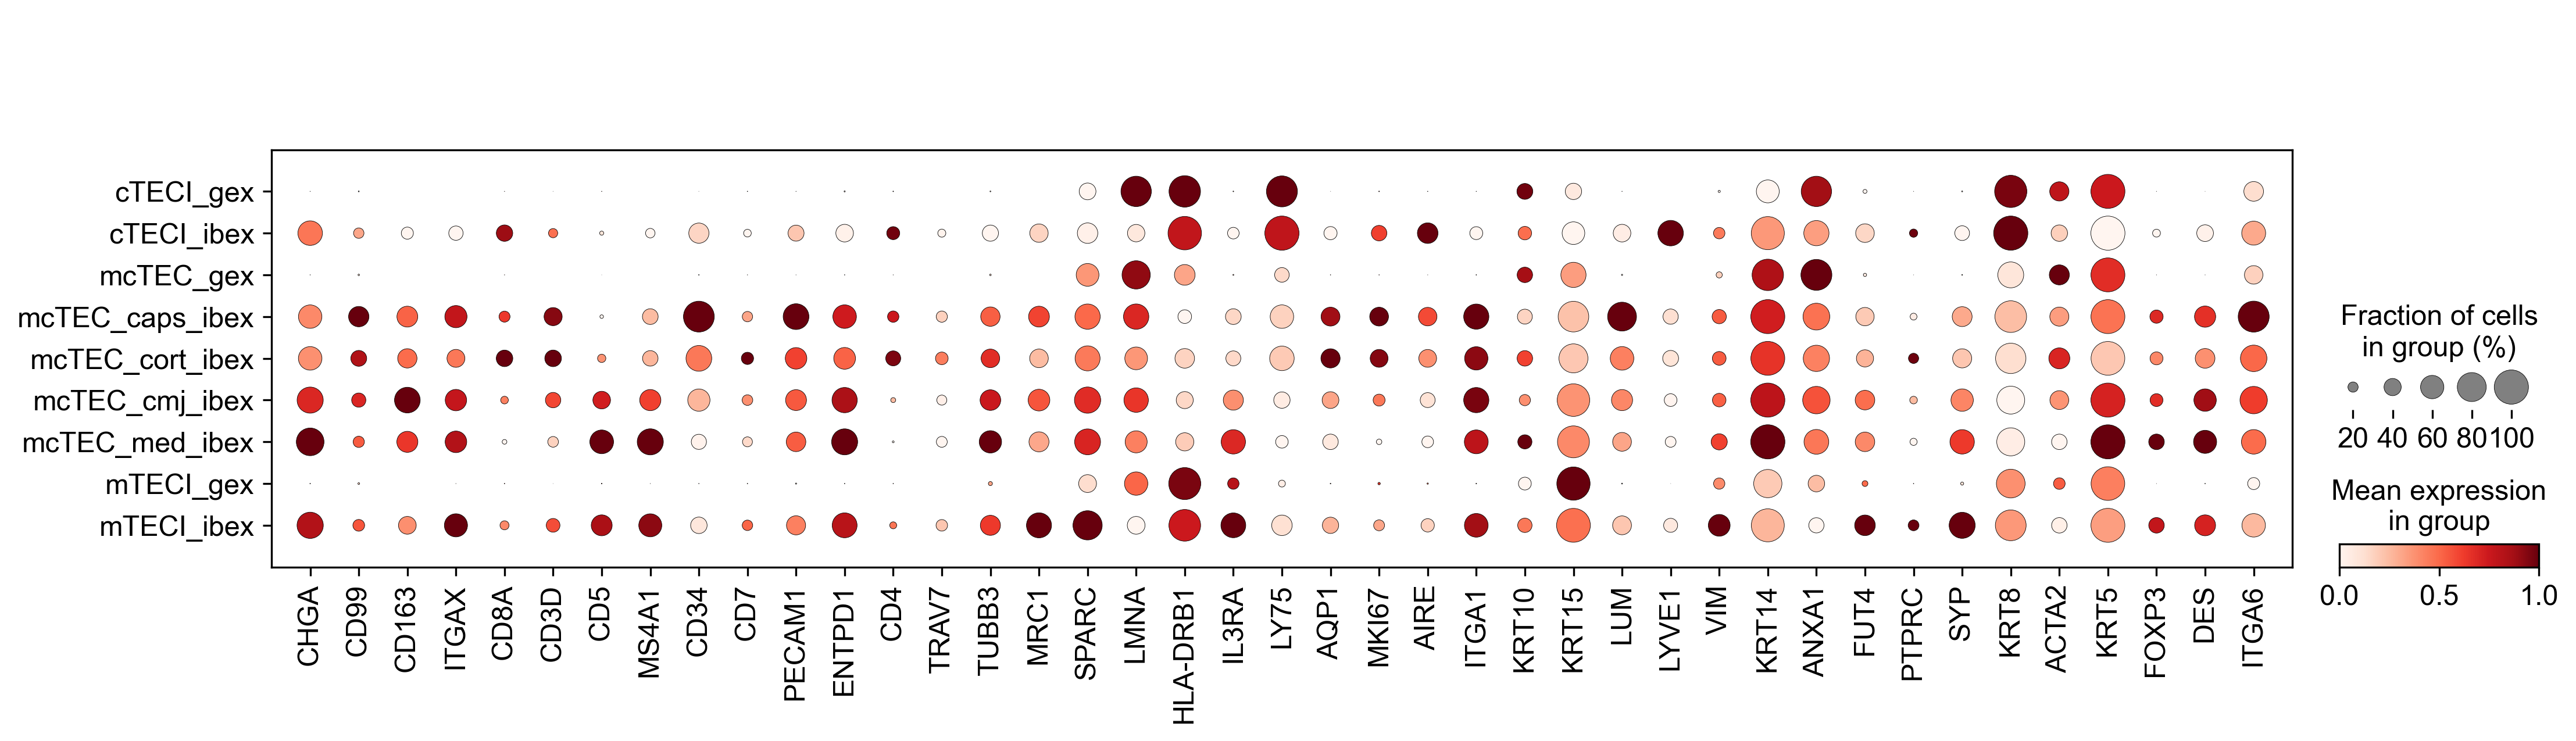

In [22]:
sc.pl.dotplot(gex_ibex[gex_ibex.obs['anno_mcTEC'].isin(cells_all),],
              var_names=gex_ibex.var_names,groupby='anno_mcTEC',standard_scale='var',
              categories_order = cells_all, save = "mcTEC_types_ibex_vs_gex_comparison_0.25thrs.pdf")


/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


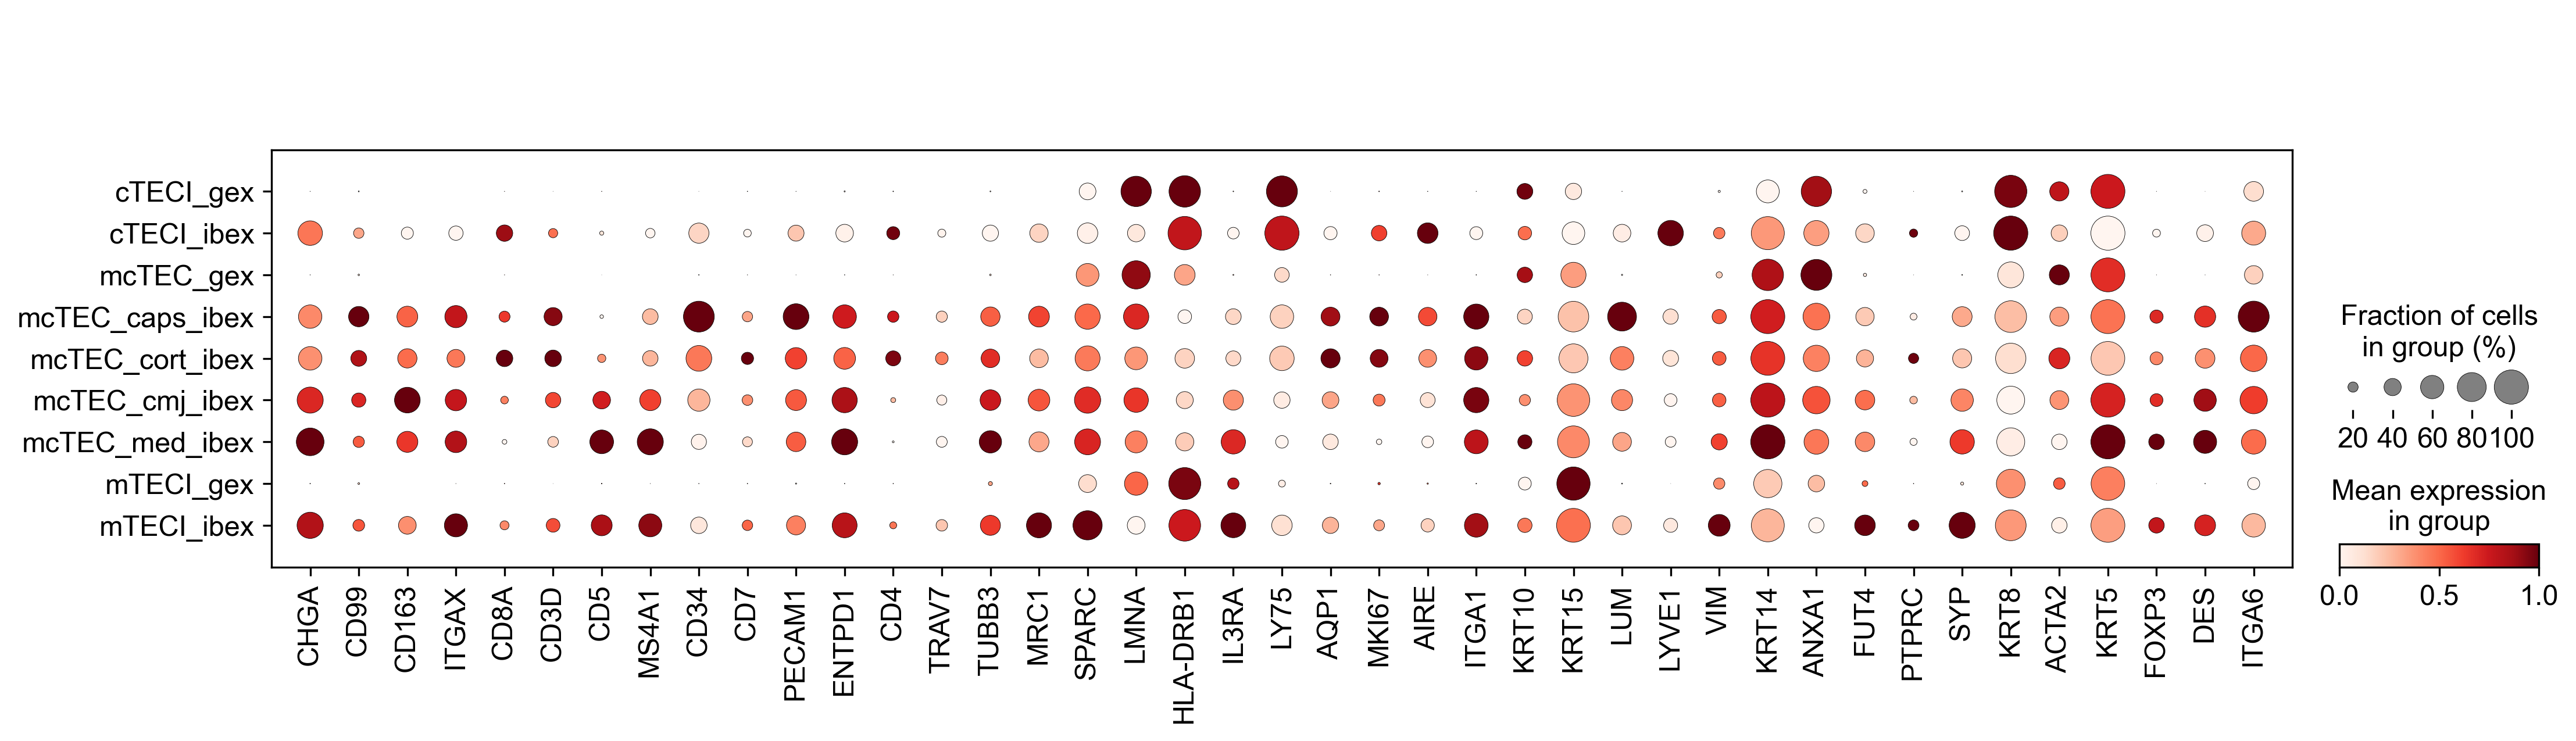

In [23]:
sc.pl.dotplot(gex_ibex[gex_ibex.obs['anno_mcTEC'].isin(cells_all),],
              var_names=gex_ibex.var_names,groupby='anno_mcTEC',standard_scale='var',
              categories_order = cells_all, save = "mcTEC_types_ibex_vs_gex_comparison_0.5thr.pdf")


In [30]:
# cells = ['uncommitted','committed_CD4neg(P)','committed_CD4neg','committed_CD4pos', 'DP_early_CD31','DP(P)_early', 'DP(Q)_early', 'DP(Q)_rearr','DP_pos_sel','DP_4hi8lo', 'SP_CD4_immature', 'SP_CD4_semimature', 'SP_CD4_mature','SP_CD8_immature','SP_CD8_semimature','SP_CD8_mature',]
cells_filt2 = ['cTECIII_ibex', 'cTECII_ibex', 'cTECI_ibex','mcTEC_caps_ibex', 
         'mcTEC_cmj_ibex', 'mTECI_ibex','mTECII_ibex', 'mTECIII_ibex']

In [31]:
genes_sel = ['SPARC', "LMNA", 'HLA-DRB1', 'LY75', 'KRT10','KRT15', 'KRT14', 'ANXA1', 'KRT8', 'ACTA2', 'KRT5','ITGA6']

In [35]:
os.getcwd()

'/nfs/team205/ny1/ThymusSpatialAtlas/Figure_4_nat'

In [36]:
import os 
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas')

In [38]:
gex_ibex[gex_ibex.obs['anno_mcTEC'].isin(cells_filt2),].obs['anno_mcTEC'].value_counts()

mTECI_ibex         9588
mcTEC_caps_ibex    6926
cTECIII_ibex       5016
mTECII_ibex        2392
cTECI_ibex         2234
mcTEC_cmj_ibex     1586
mTECIII_ibex       1007
cTECII_ibex         191
Name: anno_mcTEC, dtype: int64

/nfs/team205/vk8/miniconda/envs/scvi-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


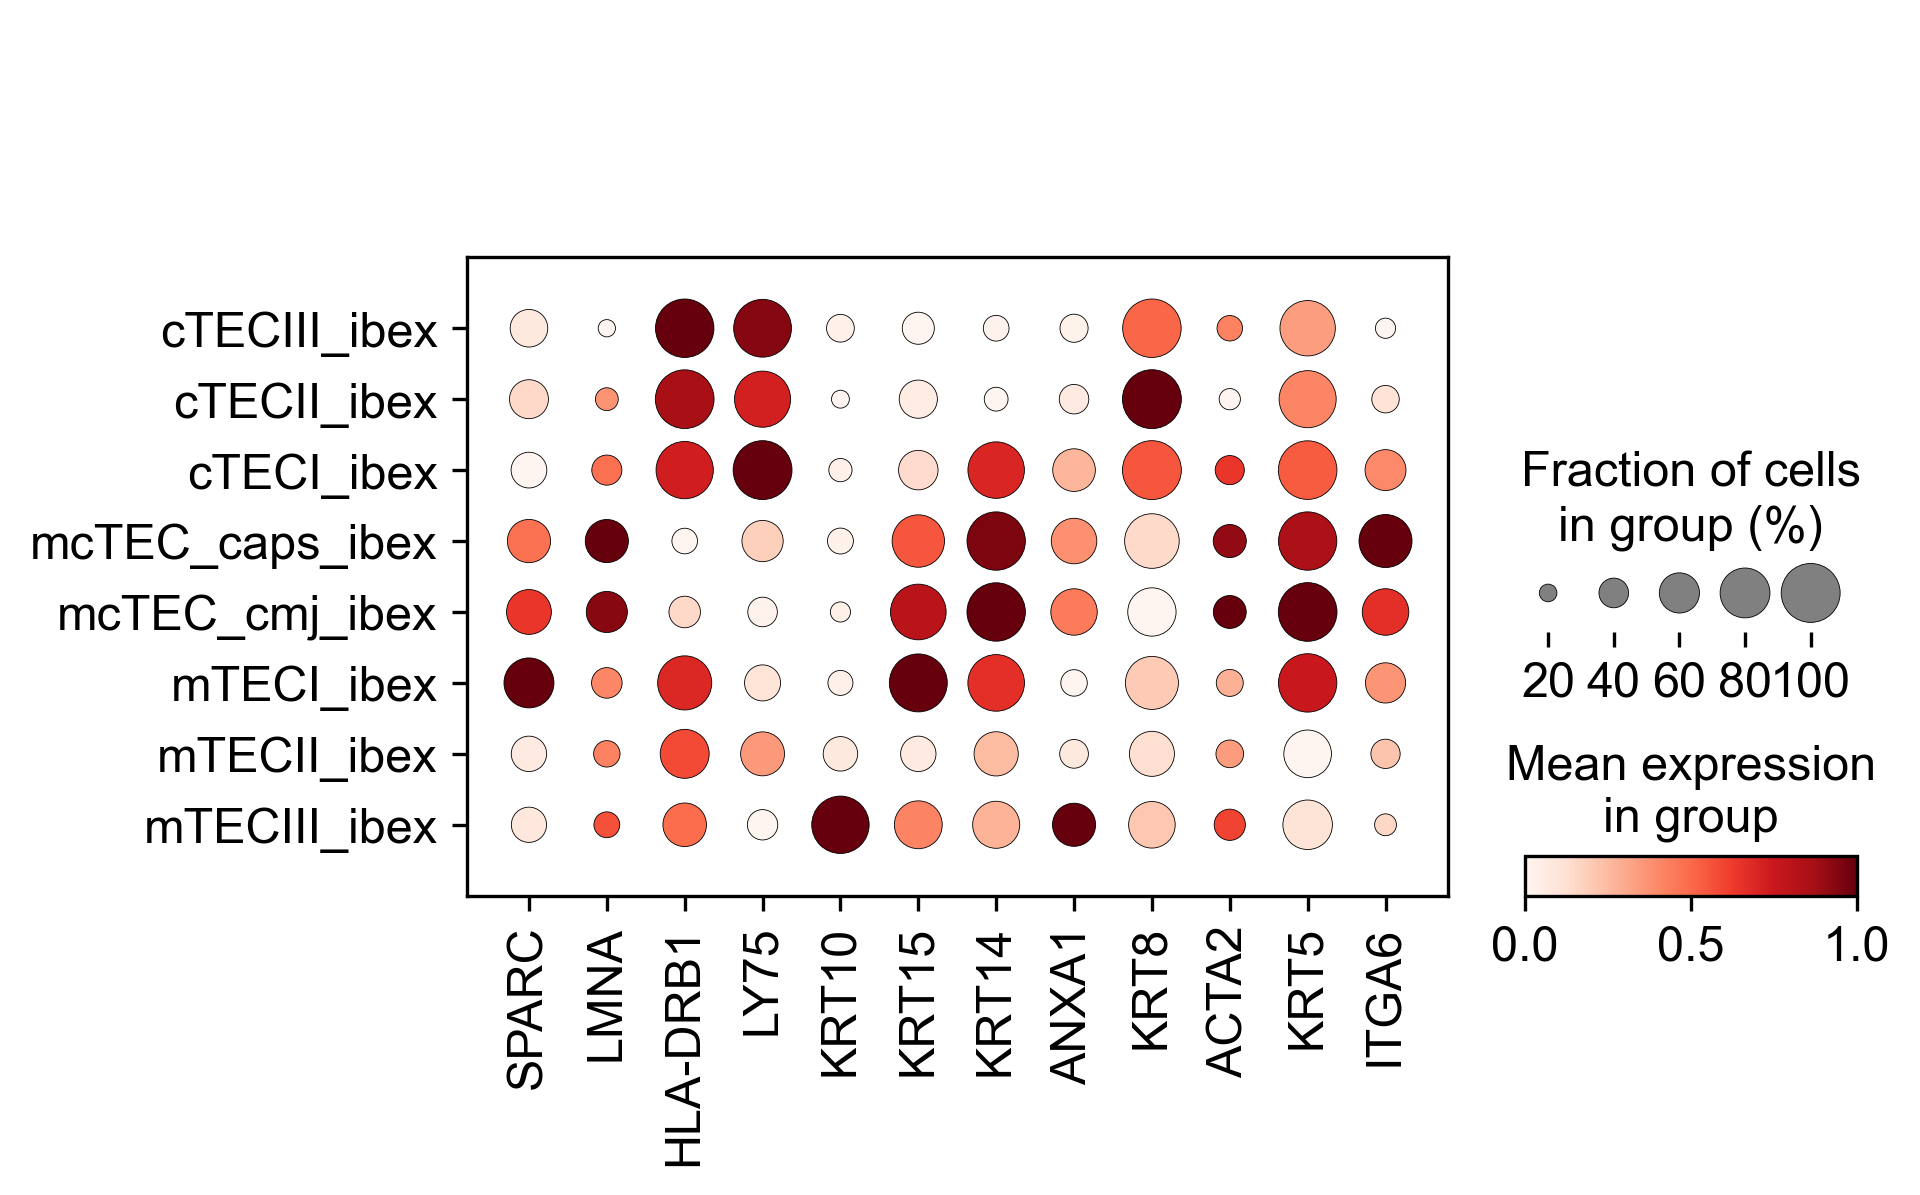

In [37]:

sc.pl.dotplot(gex_ibex[gex_ibex.obs['anno_mcTEC'].isin(cells_filt2),],
              var_names=genes_sel,groupby='anno_mcTEC',standard_scale='var',
              categories_order = cells_filt2, save = 'mcTEC_types_ibex_vs_gex_comparison_filt_0.25thr.pdf')
